In [23]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import json
from tqdm import tqdm

folder = os.path.join("..", "0_dataset", "syslog")
filename = 'original_label_syslog.csv'
filenames = ['label_syslog_mirai.csv', 'label_syslog_disk_wipe.csv', 'label_syslog_ransomware.csv',
                  'label_syslog_resource_hijacking.csv', 'label_syslog_end_point_dos.csv']
filename_label = 'preprocess_label_syslog.csv'
label_table_path = 'labels_table.json'

1. Preprocessing (count event per second)  
Data collecting tool: **Rsyslog**  
Features extraction tool: **Drain**

In [33]:
col_list = ['HostName', 'EventTemplate', 'Timestamp', 'Label']
one_hot_col_list = ['EventTemplate']
# del_col_list = ['HostName', 'Timestamp']
del_col_list = ['HostName']
df = pd.read_csv(os.path.join(folder, filename), usecols=col_list)
labels = sorted(df['Label'].unique())

print('label uniques: {0}'.format(labels))
print('number of timestamp: {0}'.format(len(df['Timestamp'].unique())))

df = pd.get_dummies(df, columns=one_hot_col_list)

hostnames = df['HostName'].unique()

# simple analysis
for tmp_filename in filenames:
    print("\n")
    print("-------------------------------------\n")
    print("file name:{0}".format(tmp_filename))
    tmp_filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(tmp_filename)

    # simple analysis
    tmp_labels = sorted(tmp_df['Label'].unique())
    print('labels: {0}'.format(tmp_labels))

df_count_vector = pd.DataFrame()

df_machines = []
unique_timestamps_machines = []
for hostname in hostnames:
    df_machines.append(df[df['HostName'] == hostname])

for df_machine in df_machines:
    unique_timestamps = list(set(df_machine['Timestamp']))
    unique_timestamps_machines.append(unique_timestamps)

# record templates by each second and machine
for i in range(len(df_machines)):
    df_machine = df_machines[i]
    tmp_unique_timestamps = unique_timestamps_machines[i]
    for tmp_timestamp in tqdm(tmp_unique_timestamps):
        tmp_df = df_machine[df_machine['Timestamp'] == tmp_timestamp]
        tmp_df = tmp_df.drop(columns=del_col_list)
        classes_num = {}
        for j in labels:
            class_num = len(tmp_df[tmp_df['Label'] == j])
            if j != 0 and class_num > 0:
                classes_num[j] = class_num
        sum_one_hot = tmp_df.sum()
        
        # label according to most frequent technique
        max_num = 0
        max_label = 0
        for key in classes_num:
            if classes_num[key] > max_num:
                max_num = classes_num[key]
                max_label = key
            
        sum_one_hot = pd.DataFrame(sum_one_hot).transpose()
        sum_one_hot['Label'] = max_label
        sum_one_hot['Timestamp'] = tmp_timestamp
        
        df_count_vector = pd.concat([df_count_vector, sum_one_hot], ignore_index=True)
        
output_file = os.path.join(folder, filename_label)
df_count_vector.to_csv(output_file, encoding='utf-8', index=False)

label uniques: [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17]
number of timestamp: 10303


-------------------------------------

file name:label_syslog_mirai.csv
labels: [0, 1, 2, 5, 9, 11, 13]


-------------------------------------

file name:label_syslog_disk_wipe.csv
labels: [0, 1, 4, 8, 14]


-------------------------------------

file name:label_syslog_ransomware.csv
labels: [0, 1, 7, 12, 15]


-------------------------------------

file name:label_syslog_resource_hijacking.csv
labels: [0, 1, 6, 8, 12]


-------------------------------------

file name:label_syslog_end_point_dos.csv
labels: [0, 12, 17]


100%|██████████| 1/1 [00:00<00:00, 100.01it/s]


2. Training preparation

In [34]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

df = pd.read_csv(os.path.join(folder, filename_label))
del_list = ['Timestamp']

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# drop duplicated
df.drop_duplicates(keep=False, inplace=True)
df.drop(columns=del_list, inplace=True)


# # data cleaning for normal data
# df_tmp = df.loc[df['Label'] == 0].copy()
# df_tmp.drop_duplicates(keep=False, inplace=True)
# df.drop(df[df['Label'] == 0].index, inplace=True)
# df = pd.concat([df, df_tmp])


# # feature scaling
# y_tmp = df['Label']
# df.drop(columns=['Label'], inplace=True)
# for feature in df.columns.values:
#     # scaler = RobustScaler().fit(df[feature].values.reshape(-1, 1))
#     scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
#     # scaler = Normalizer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = QuantileTransformer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = PowerTransformer().fit(df[feature].values.reshape(-1, 1))
#     df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
# df = pd.concat([df, y_tmp], axis=1)


# feature selection
# delete features with all the same value
y_tmp = df['Label']
y = df['Label'].values.astype(int)
df.drop('Label', axis=1, inplace=True)
selector = VarianceThreshold(threshold=0)
selector.fit(df)
# print(selector.variances_)
constant_columns = [column for column in df.columns
                    if column not in 
                    df.columns[selector.get_support()]]
df.drop(labels=constant_columns, axis=1, inplace=True)

# delete similar features
df_tmp = df
corr_features = set()
corr_matrix = df_tmp.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
df.drop(labels=corr_features, axis=1, inplace=True)

df = pd.concat([df, y_tmp], axis=1)


# # balancing extremly few class
# for class_label in df['Label'].unique():
#     while len(df[df['Label'] == class_label]) < 50:
#         tmp_df = df[df['Label'] == class_label]
#         df = pd.concat([df, tmp_df])


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, "select_"+filename_label)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 21218
origin features: 79
remain data number: 21205
remain features: 52


3. Visualization (data number)


Data number:
class0: 89604
class1: 286417
class2: 57
class4: 1043
class5: 9
class6: 13707
class7: 13115
class8: 37970
class9: 63
class11: 2787
class12: 99181
class13: 2949
class14: 2014
class15: 2022
class17: 2647


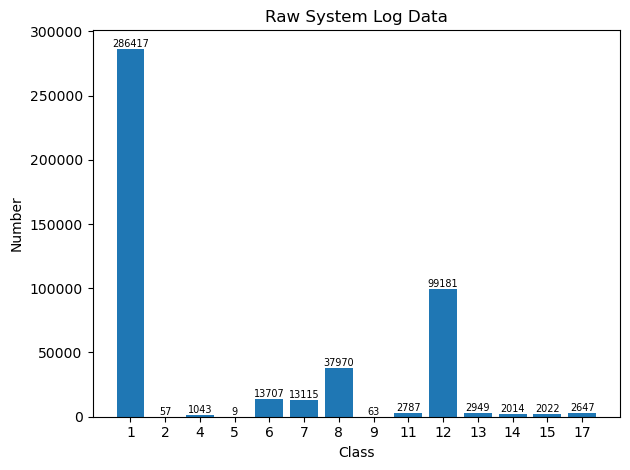

In [35]:
def bar_class_num(technique_data_size):
    class_num = np.arange(len(technique_data_size))
    # data_nums = plt.bar(class_num, technique_data_size, 0.2)
    data_nums = plt.bar(class_num, technique_data_size)
    for item in data_nums:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
            fontsize = 7,
        )
    labels.pop(0)
    plt.xticks(class_num, labels)
    plt.xlabel("Class")
    plt.ylabel("Number")
    # plt.title("Preprocessed System Log Data")
    plt.title("Raw System Log Data")
    plt.tight_layout()
    plt.savefig("log.png", dpi=400)
    plt.show()

technique_data_size = []
# df = pd.read_csv(os.path.join(folder, "select_"+filename_label))
df = pd.read_csv(os.path.join(folder, "original_label_syslog.csv"))
labels = df['Label'].unique()
labels = [int(i) for i in labels]
labels.sort()
with open("labels_table.json", "r") as f:
    label_table = json.load(f)

for i in labels:
    if i != 0:
        class_data_size = len(df[df['Label'] == i])
        technique_data_size.append(class_data_size)

print("\nData number:")
for i in labels:
    print("class{0}: {1}".format(i, len(df[df['Label'] == i])))

bar_class_num(technique_data_size)